---

# EN2550 2021: Object Counting on a Convey Belt<a href="#EN2550-2021:-Object-Counting-on-a-Convey-Belt" class="anchor-link"></a>

### *Index Number: 180631J*
### *Name: Thalagala B.P.*
### *Submitted on: July 8, 2021*


---

In this assignment, you will be counting and tracking the hexagonal nuts
on a moving convey belt.

### Let's first import required libraries<a href="#Let&#39;s-first-import-required-libraries" class="anchor-link"></a>

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
# magic commands
%config IPCompleter.greedy=True
%config Completer.use_jedi = False
%matplotlib inline

### Let's load and visualize the template image and the convey belt snapshot at a given time.<a href="#Let&#39;s-load-and-visualize-the-template-image-and-the-convey-belt-snapshot-at-a-given-time." class="anchor-link">¶</a>


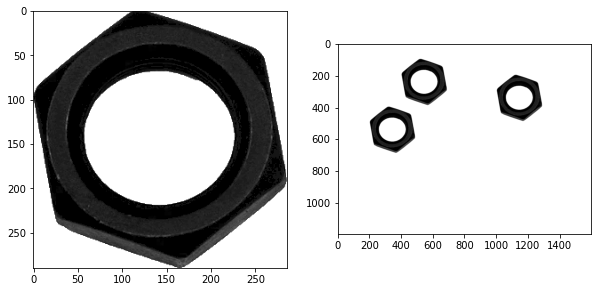

In [2]:
template_im = cv.imread(r'template.png', cv.IMREAD_GRAYSCALE)
belt_im =  cv.imread(r'belt.png', cv.IMREAD_GRAYSCALE)

fig, ax = plt.subplots(1,2,figsize=(10,10))
ax[0].imshow(template_im, cmap='gray')
ax[1].imshow(belt_im, cmap='gray')
plt.show()

## Part-I :<a href="#Part-I-:" class="anchor-link"></a>

### Otsu's thresholding<a href="#Otsu&#39;s-thresholding" class="anchor-link"></a>

* Otsu's method avoids having to choose a value and determines an optimal global threshold value from the image histogram automatically. It is returned as the first output.

In [3]:
th_t, img_t = cv.threshold(template_im,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
th_b, img_b = cv.threshold(belt_im,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU) 

### Morphological closing<a href="#Morphological-closing" class="anchor-link"></a>

Carrying out morphological closing to remove small holes inside the
foreground. Use a \$3 \\times 3\$ kernel. 

1. Erosion: a pixel element is '1' if all the pixel under the kernel is '1'. So it decreases the white region
2. Dilation: a pixel element is '1' if atleast one pixel under the kernel is '1'. So it increases the white region

Morphological closing is just Dilation followed by Erosion.

In [4]:
# 3x3 matrix with all ones, with uint8 dtype
kernel = cv.getStructuringElement(cv.MORPH_RECT, (3,3)) 
closing_t = cv.morphologyEx(img_t, cv.MORPH_CLOSE, kernel) # Dilation followed by Erosion
closing_b = cv.morphologyEx(img_b, cv.MORPH_CLOSE, kernel) # Dilation followed by Erosion

### Connected component analysis<a href="#Connected-component-analysis" class="anchor-link"></a>

Apply the `connectedComponentsWithStats` function



==================Template Image==================
Number of labels:  2


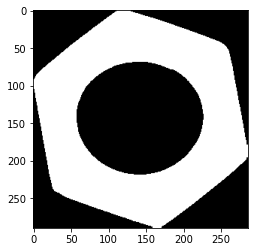

Stats: 
 [[    0     0   286   290 42290]
 [    0     0   286   290 40650]] 

Centroids: 
 [[142.18770395 145.19172381]
 [142.82489545 143.780369  ]] 

====================Belt Image====================
Number of labels:  4


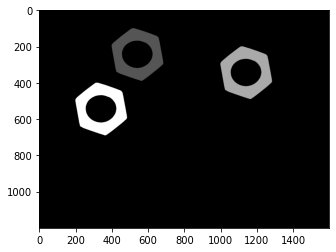

Stats: 
 [[      0       0    1600    1200 1798161]
 [    400     100     286     290   40613]
 [   1000     200     286     290   40613]
 [    200     400     286     290   40613]] 

Centroids: 
 [[ 807.85728475  614.56805258]
 [ 542.82567158  243.78479797]
 [1142.82567158  343.78479797]
 [ 342.82567158  543.78479797]] 



In [5]:
retval_t, labels_t, stats_t, centroids_t = cv.connectedComponentsWithStats(closing_t)
retval_b, labels_b, stats_b, centroids_b = cv.connectedComponentsWithStats(closing_b)

def cca_stats(img_name, retval, labels, stats, centroids):  
    print(img_name.center(50,"="))
    print("Number of labels: ", retval)
    plt.imshow(labels.astype('uint8'), cmap ='gray'); plt.show()
    print("Stats: \n", stats,'\n') # stats[label,cv.CC_STAT_quantity])
    print("Centroids: \n", centroids,'\n')
    
cca_stats("Template Image", retval_t, labels_t, stats_t, centroids_t)
cca_stats("Belt Image", retval_b, labels_b, stats_b, centroids_b)

-   How many connected components are detected in each image?<br>
**Template Image** = 2 (*including background*)<br> 
**Belt Imag**e = 4 (*including background*)

-   What are the statistics? Interpret these statistics.<br>
Statistics are properties related to each connected component. Statistics object is a 2D array where each column represent a different quantity related to a given connected component as described below.

**Column 1:** *cv.CC_STAT_LEFT*: the leftmost (x) coordinate which is the inclusive start of the bounding box in the horizontal direction.<br>
**Column 2:** *cv.CC_STAT_TOP*: the topmost (y) coordinate which is the inclusive start of the bounding box in the vertical direction.<br>
**Column 3:** *cv.CC_STAT_WIDTH*: the horizontal size of the bounding box.<br>
**Column 4:** *cv.CC_STAT_HEIGHT*: the vertical size of the bounding box.<br>
**Column 5:** *cv.CC_STAT_AREA*: the total area (in pixels) of the connected component.<br>

-   What are the centroids?<br>
Each row of the 2D `Cenroids` obejct represents the (x,y) coordinates of centroid of the corresponding connected component.

### Contour analysis<a href="#Contour-analysis" class="anchor-link"></a>

Use `findContours` function to retrieve the *extreme outer* contours.

Contours is a Python list of all the contours in the image. Each individual contour is a Numpy array of (x,y) coordinates of boundary points of the object. Display these countours.

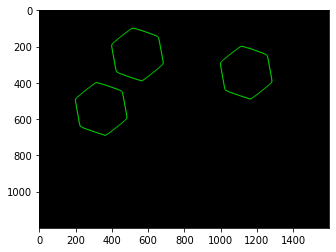

(<matplotlib.image.AxesImage at 0x193957b5820>, None)

In [6]:
# cv.RETR_EXTERNAL retrieve only the extreme outer contours
contours_t,_ = cv.findContours(closing_t, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
contours_b,_ = cv.findContours(closing_b, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# Visualizing contours (-1 argument to plot all the contours)
im_contours_belt = np.zeros((belt_im.shape[0],belt_im.shape[1],3), np.uint8)
conts = cv.drawContours(im_contours_belt, contours_b, -1, (0,255,0), 3).astype('uint8')
plt.imshow(conts), plt.show()

### Count the number of matching hexagonal nuts in `belt.png`.<a href="#Count-the-number-of-matching-hexagonal-nuts-in-belt.png." class="anchor-link"></a>

`cv.matchShapes` function enables us to compare two shapes, or two contours and returns a metric showing the similarity. The lower the result, the better match it is. `retval=cv.matchShapes(contour1, contour2, method, parameter)
`

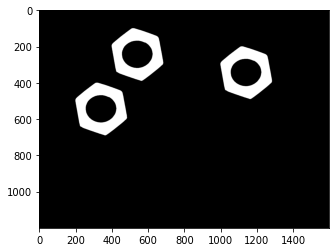

Contour  1 --> 0.00010071698397173812
Contour  2 --> 0.00010071698397950968
Contour  3 --> 0.00010071698397506879


In [7]:
label = 1 # remember that the label of the background is 0
belt = ((labels_b >= label)*255).astype('uint8')  
plt.imshow(belt, cmap ='gray'),plt.show()
belt_cont,_ = cv.findContours(belt, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)  
for j,c in enumerate(belt_cont):
        print("Contour ", j +1,"-->", cv.matchShapes(contours_t[0], c, cv.CONTOURS_MATCH_I1, 0.0))

## Part - II<a href="#Part---II" class="anchor-link"></a>

### Frame tracking through image moments.<a href="#Frame-tracking-through-image-moments." class="anchor-link"></a>

Use the `cv.contourArea()`, see
[this](https://docs.opencv.org/master/dd/d49/tutorial_py_contour_features.html)
and calculate the the area of the `contours_b[1]`


In [8]:
ca = cv.contourArea(contours_b[1])
print(ca)

60059.5


Use the `cv.moments` to extract the x and y coordinates of the centroid
of `contours_b[1]`.


In [9]:
M = cv.moments(contours_b[1])
print("Area = ", M['m00'])

cx, cy = int(M['m10']/M['m00']), int(M['m01']/M['m00'])
print("Centroid = ({}, {})".format(cx,cy))

Area =  60059.5
Centroid = (1142, 343)


Make a variable called `count` to represent the number of contours and
set it to the value 1. Make an np array \[cx, cy, ca, count\] and name
this as `object_prev_frame`



In [10]:
count = 1
object_prev_frame = np.array([cx, cy, ca, count])

Similarly, you can create the `object_curr_frame`(to describe the
current values) and define the threshold `delta_x` to check whether the
corresponding element of both the `object_curr_frame` and
`object_prev_frame` are less than the `delta_x`. You can set `delta_x`
as 15 or so. (Here the `delta_x` can be thought of as the movement of
the cx from frame to frame)


In [11]:
delta_x = 15

## Part - III<a href="#Part---III" class="anchor-link"></a>

### 1. Implement the function `get_indexed_image`, which takes an image as the input, performs thresholding, closing, and connected component analysis and return retval, labels, stats, centroids. (Grading)<a href="#1.-Implement-the-function-get_indexed_image,-which-takes-an-image-as-the-input,-performs-thresholding,-closing,-and-connected-component-analysis-and-return-retval,-labels,-stats,-centroids.-(Grading)" class="anchor-link"></a>


In [12]:
def get_indexed_image(im):
    """ Thresholding, closing, and connected component analysis lumped
    """ 

    _, img = cv.threshold(im,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (3,3)) 
    closing = cv.morphologyEx(img, cv.MORPH_CLOSE, kernel) # Dilation followed by Erosion
    retval, labels, stats, centroids = cv.connectedComponentsWithStats(closing)

    return retval, labels, stats, centroids 

### 2. Implement the function `is_new`, which checks the dissimilarity between 2 vectors. (Grading)<a href="#2.-Implement-the-function-is_new,-which-checks-the-dissimilarity-between-2-vectors.-(Grading)" class="anchor-link"></a>


In [13]:
def is_new(a, b, delta, i):
    """ Vector Dissimilarity with an Array of Vectors
    Checks if vector b is similar to a one or more vectors in a outside 
    the tolerances specified in delta.
    
    vector i specifies which elements in b to compare with those in a. 
    """    
    
    absolute_different = np.absolute(a - b)
    absolute_different[:,i] = (absolute_different[:,i] > delta[i]) 
    
    return absolute_different[:,i].all() # all(axis=0) over columns

In [14]:
# check is_new  expected answer False
a = np.array([[1.36100e+03, 5.53000e+02, 5.99245e+04, 2.00000e+00],
              [7.61000e+02, 4.53000e+02, 5.99385e+04, 1.00000e+00],
              [1.55200e+03, 2.43000e+02, 6.00585e+04, 3.00000e+00]])

b = np.array( [7.51000e+02, 4.53000e+02, 5.99385e+04, 3.00000e+00])
delta = np.array([delta_x])
i = np.array([0])

assert is_new(a, b, delta, i) == False, " Check the function "

### 3. If the array `a` is in the shape of (number of nuts , len(object_prev_frame)) ( i.e. array `a` is made by stacking all the `object_prev_frame` for each frame. If b is in the form of \[cx, cy, ca, count\], write the function `prev_index` to find the index of a particular nut in the previous frame. (Grading)<a href="#3.-If-the-array-a-is-in-the-shape-of-(number-of-nuts-,-len(object_prev_frame))-(-i.e.-array-a-is-made-by-stacking-all-the-object_prev_frame-for-each-frame.-If-b-is-in-the-form-of-%5Bcx,-cy,-ca,-count%5D,-write-the-function-prev_index-to-find-the-index-of-a-particular-nut-in-the-previous-frame.-(Grading)" class="anchor-link"></a>


In [15]:
def prev_index(a, b, delta, i):
    """ Returns Previous Index
    Returns the index of the apppearance of the object in the previous frame.
    (See thee example in the next cell)
    """
    index = -1
    absolute_different = np.absolute(a - b)
    # thresholding  depending on the movement of the cx from frame to frame
    absolute_different[:,i] = (absolute_different[:,i] <= delta[i])  
    index = np.where(absolute_different[:,i])[0] # get the scalar out of npArray.
    
    return index    

In [16]:
# check prev_index  expected answer 1
a = np.array([[1.36100e+03, 5.53000e+02, 5.99245e+04, 2.00000e+00],
              [7.61000e+02, 4.53000e+02, 5.99385e+04, 1.00000e+00],
              [1.55200e+03, 2.43000e+02, 6.00585e+04, 3.00000e+00]])

b = np.array( [7.51000e+02, 4.53000e+02, 5.99385e+04, 3.00000e+00])
delta = np.array([delta_x])
i = np.array([0])

assert prev_index(a,b,delta,i) == 1, " Check the function "

### Access video frames
You can use following code snippet load and access each frame of a video


In [17]:
color_frames = [] # list to store RGB frames

cap = cv.VideoCapture('conveyor_with_rotation.mp4') # give the correct path here
while cap.isOpened(): 
    ret, frame = cap.read()
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    color_frames.append(frame)
    cv.imshow("Frame", frame)
    if cv.waitKey(1) == ord('q'):  
        break
        
cap.release()
cv.destroyAllWindows()

Can't receive frame (stream end?). Exiting ...


### 3. Implement a code to detect hexagonal nuts in a moving convey belt. (Grading)<a href="#3.-Implement-a-code-to-detect-hexagonal-nuts-in-a-moving-convey-belt.-(Grading)" class="anchor-link"></a>

## Steps:<a href="#Steps:" class="anchor-link"></a>

1.  Use the above code snippet to access each frame and remember to
    convert the frame into grey scale. Name the variable as `grey`
2.  Call `get_indexed_image` and extract
    `retval, labels, stats, centroids`.
3.  Find contours of all nuts present in a given frame of the belt.
4.  Initiate a 3-D array with zeros to draw contours. Call this
    `im_contours_belt`
5.  Draw each contour. Use `cv.drawContours`. [See
    this](https://docs.opencv.org/master/d4/d73/tutorial_py_contours_begin.html)

In [18]:
gray_frames = []  # list to store Gray Scale frames
cap = cv.VideoCapture('conveyor_with_rotation.mp4') # give the correct path here
print("Video capturing is in progress...")
while cap.isOpened(): 
    ret, frame = cap.read()
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY) # convert to grayscale
    gray_frames.append(frame) # store the grayscale frame images
    
    if cv.waitKey(1) == ord('q'): #keyboard interruption
        break
        
cap.release()
cv.destroyAllWindows()
print("Video capturing completed.")

Video capturing is in progress...
Can't receive frame (stream end?). Exiting ...
Video capturing completed.


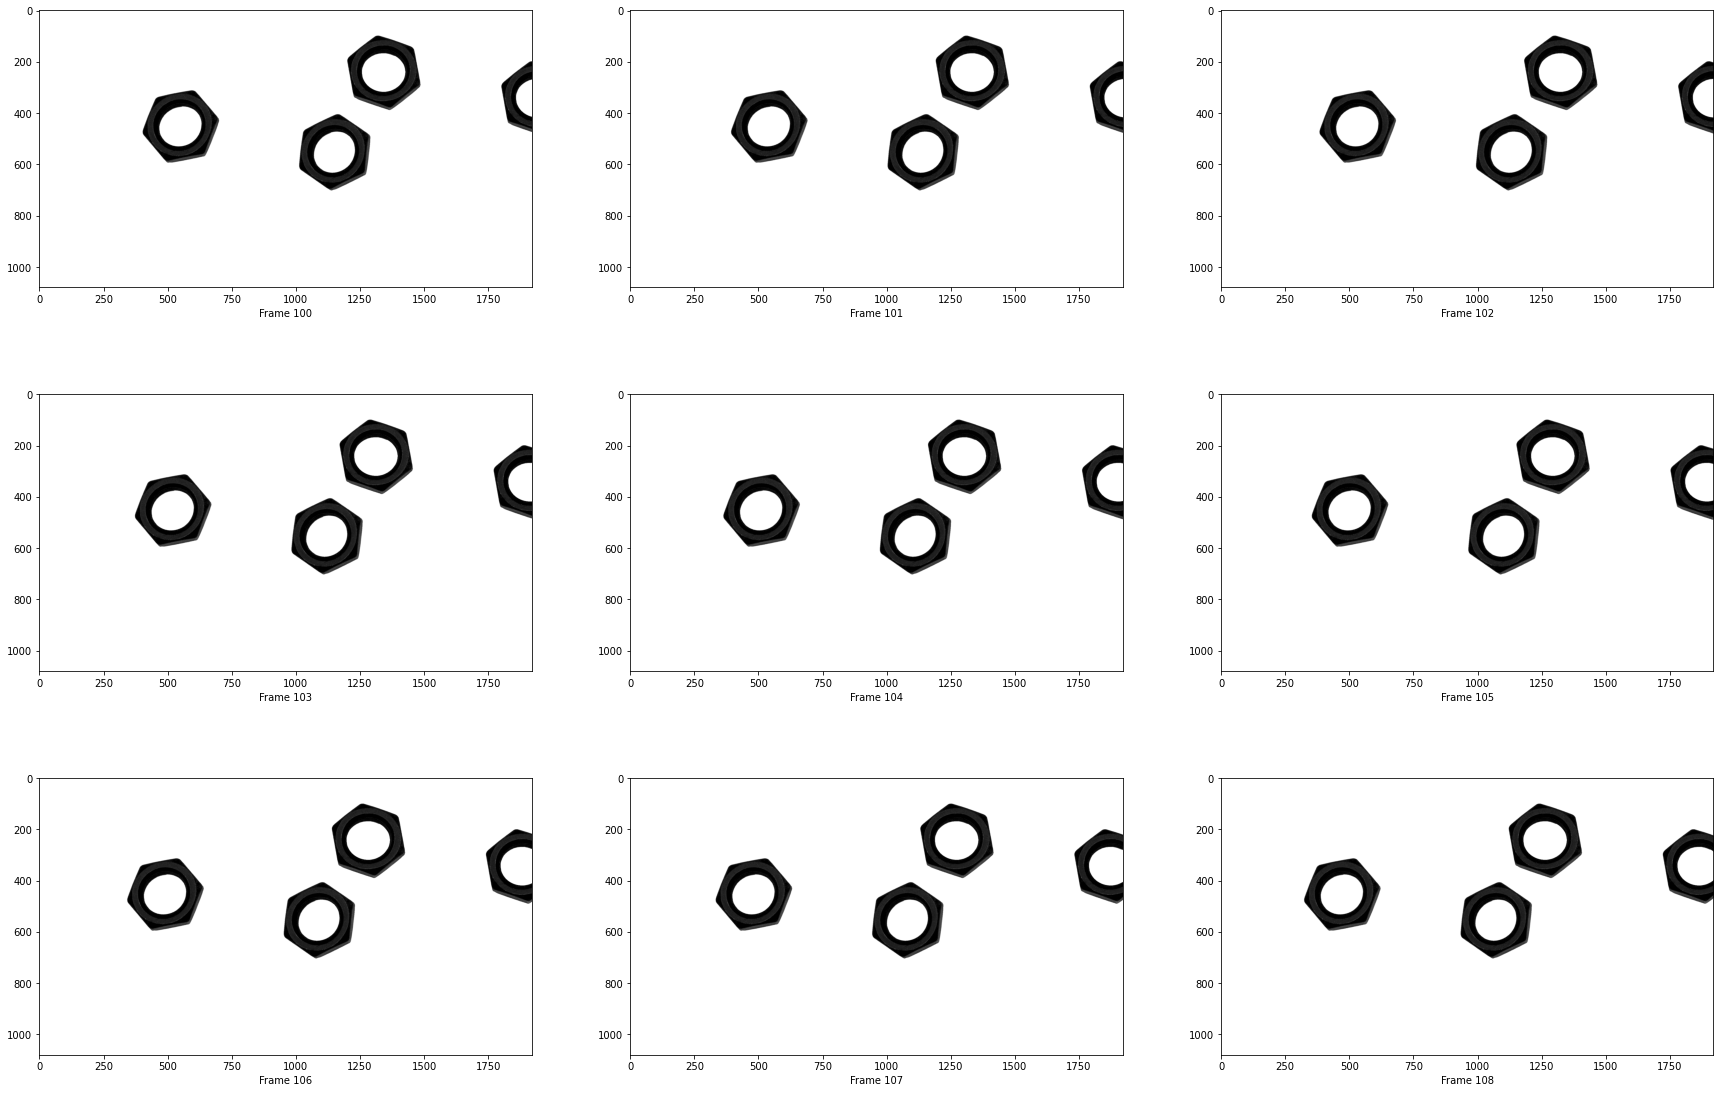

In [19]:
# visualizing some of the captured frames
plt.figure(figsize=(30,20))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(gray_frames[100 +i], cmap ='gray')
    plt.xlabel("Frame " + str(100 +i))
plt.show()

In [20]:
# Find contours of all nuts present in a given frame of the belt
contour_plots = []
contours_list = []
for gray in gray_frames:
    # finding contours
    _, labels, _, _ = get_indexed_image(gray) # Conn: Comp: Analysis
    belt = ((labels >= 1)*255).astype('uint8') 
    contours,_  = cv.findContours(belt, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    contours_list.append(contours)
    # plotting contours
    im_contours_belt = np.zeros((belt.shape[0],belt.shape[1],3), np.uint8)
    cont_plot = cv.drawContours(im_contours_belt, contours, -1, (0,255,0), 5).astype('uint8')
    contour_plots.append(cont_plot)

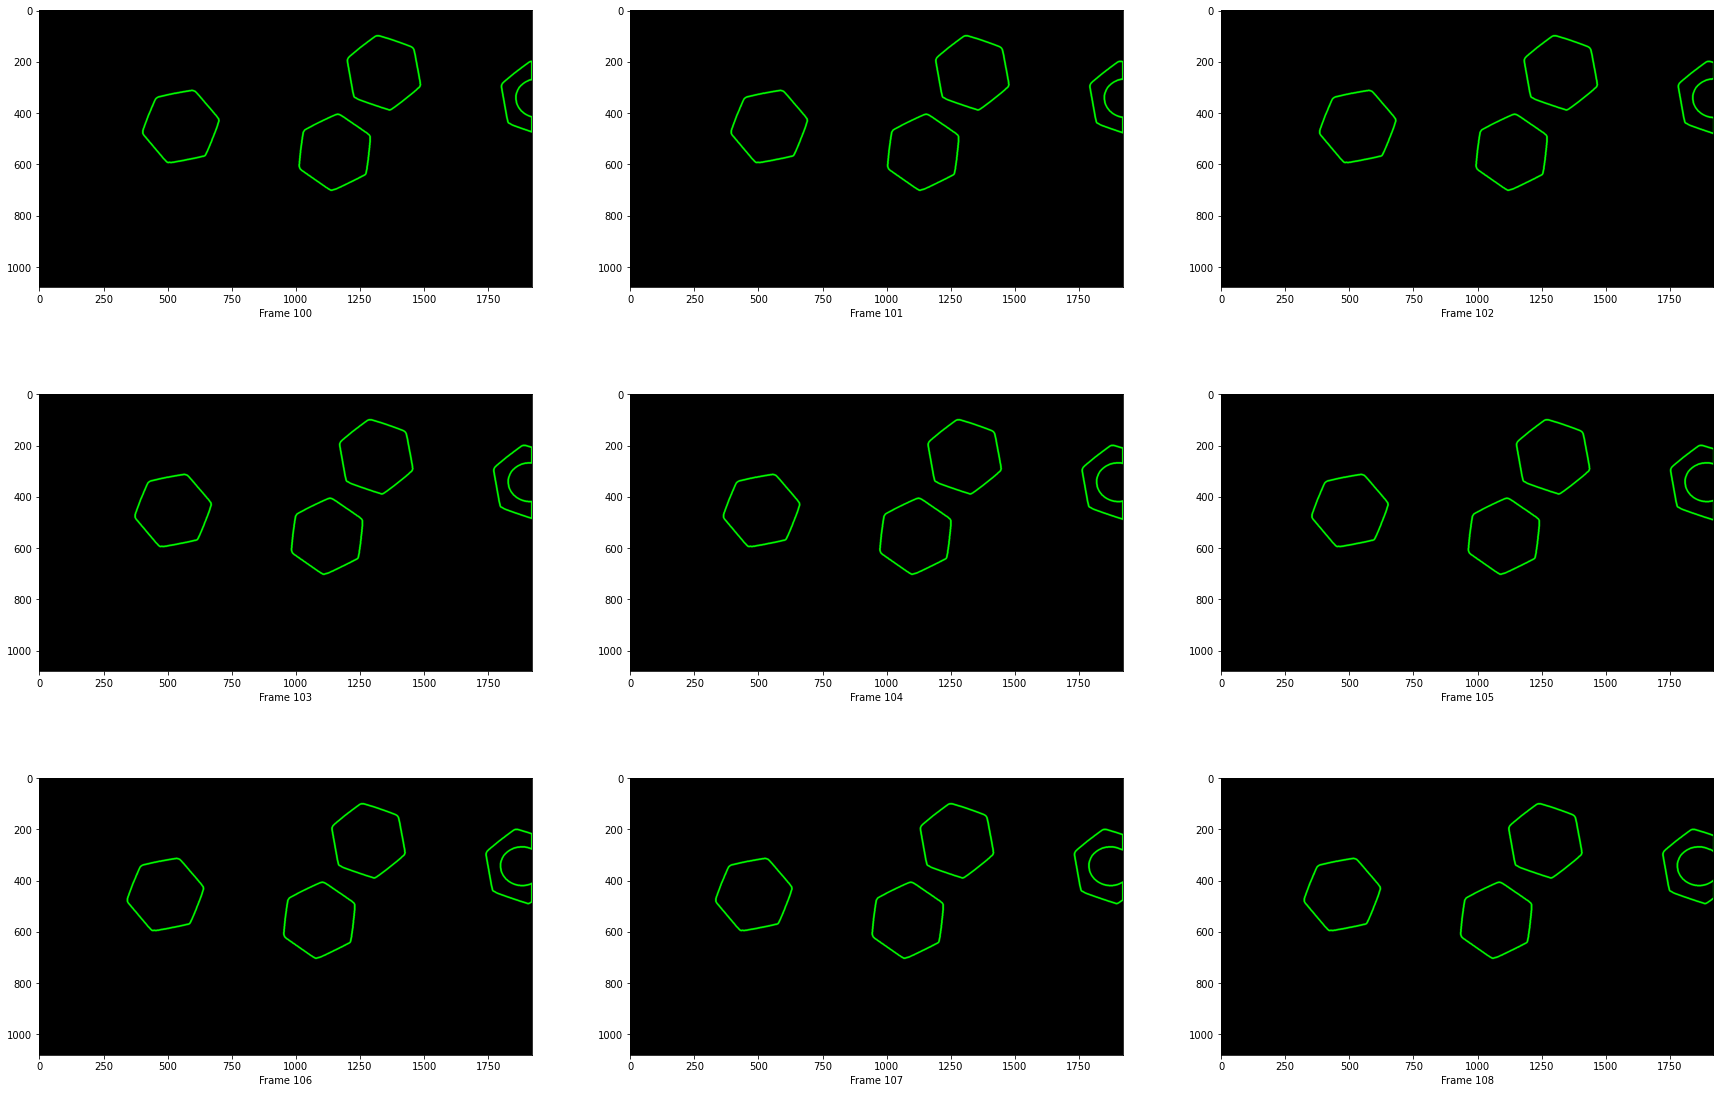

In [21]:
# visualizing contour plots on frames
plt.figure(figsize=(30,20))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(contour_plots[100 +i])
    plt.xlabel("Frame " + str(100 +i))
plt.show()

## Object detection and tracking<a href="#Object-detection-and-tracking" class="anchor-link"></a>

For each contour of the belt frame,

1.  Use `is_new` and `prev_index` functions to track each frame and get
    the indices of each nut.
2.  Write a code to detect and track hexagonal nuts in each frame.

**Hint**: *If you are thresholding on areas (template and contour) you
can use 500 as the threshold. You can set the matching threshold to be
0.5 and experiment*

In [22]:
# frame tracking through image moments
# extracting details about each contour in each frame
video = []
print("Details extraction is in progress...")
for gray in gray_frames:
    # finding contours
    _, labels, _, _ = get_indexed_image(gray)
    belt = ((labels >= 1)*255).astype('uint8') 
    contours,_  = cv.findContours(belt, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    
    count = 0 # number of nuts in a given frame
    frame = []
    
    for contour in contours:
        metric = cv.matchShapes(contours_t[0], contour, cv.CONTOURS_MATCH_I1, 0.0)
        # Set the matching threshold to be 0.5
        if metric <= 0.5: # if only a complete hexagonal nut
            count +=1
            M  = cv.moments(contour)
            ca = M['m00']
            cx, cy = int(M['m10']/M['m00']), int(M['m01']/M['m00'])
            frame.append(np.array([cx, cy, ca, count]))
    
    video.append(frame)
print("Details extraction completed.")

Details extraction is in progress...
Details extraction completed.


In [23]:
# Nut counter Implemetation
# last element keeps the number of nuts in a given frame. 
# Therefore, initial number of nuts is as follows.
total_nuts = int(video[0][-1][-1]) 
print("Number of nuts in the zeroth frame: ",total_nuts)

delta_x = np.array([15])
i = np.array([0])

prev_frame = video[0] # Reference frame to compare with the upcoming frame

for frame_num in range(1, len(video)):
    current_frame = video[frame_num] # frame to be compared    
    
    for nut in current_frame:
        # Checking the current nut with previous frame
        # if it is a new nut count it.
        if is_new(prev_frame, nut, delta_x, i):
            total_nuts +=1  
            
    prev_frame = current_frame
    
print("Total number of nuts found: ",total_nuts)       

Number of nuts in the zeroth frame:  1
Total number of nuts found:  5


In [24]:
# trackig nuts: An extension of the previous counting nuts algorithm
print("Detection and indexing is in progress...")
total_nuts = int(video[0][-1][-1]) #initial number of nuts in frame 0
delta_x = np.array([15])
i = np.array([0])
prev_frame = video[0] # Reference frame to compare with the upcoming frame

for frame_num in range(1, len(video)):
    current_frame = video[frame_num] # frame to be compared
    
    for nut in current_frame:
        # Checking the current nut with previous frame
        # if it is a new nut count it and assign a new index
        if is_new(prev_frame, nut, delta_x, i):
            total_nuts +=1
            nut[-1] = total_nuts # assignment of a new index
        
        else: 
            # to be tracked the nut must not be a new nut
            index_in_prev_frame = prev_index(prev_frame, nut, delta_x, i)
            nut_index = prev_frame[int(index_in_prev_frame)][-1]
            nut[-1] = nut_index # assign the same index it had for old nuts
        
    prev_frame = current_frame
print("Detection and indexing completed.")

Detection and indexing is in progress...
Detection and indexing completed.


In [25]:
# frame annotation with the extracted details

annotated_frames =[]
frame_num = 0
print("Frame annotation is in progress...")
for frame, color_frame, contours in zip(video, color_frames, contours_list):
    
    # Annotation was done on the frames of the original video
    img = color_frame
    y = 0 # to change the vertical position of 'object details' of a frame
    
    for nut in frame:
        # Annotate the nut index
        img = cv.putText(img, str(int(nut[-1])),\
                (int(nut[0]),int(nut[1])),cv.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 4)
        # Annotate the nut(object) details
        img = cv.putText(img, "Object {}: {:04} {:04} {:05}".format(int(nut[-1]), int(nut[0]), int(nut[1]), nut[2]),\
                         (50,850 + 70*y), cv.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 4)
        
        y +=1 # change vertical position for next object details annotation.
    
    # Annotation of the frame number and draw the extracted contours
    img = cv.putText(img, "Frame "+str(frame_num) , (50,750) , cv.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 3)
    img = cv.drawContours(img, contours, -1, (255,0,0), 5).astype('uint8')
    
    # Index number 180631J
    img = cv.putText(img, "180631J" , (50,150) , cv.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 3)
    annotated_frames.append(img)
    frame_num +=1
print("Frame annotation completed.")

Frame annotation is in progress...
Frame annotation completed.


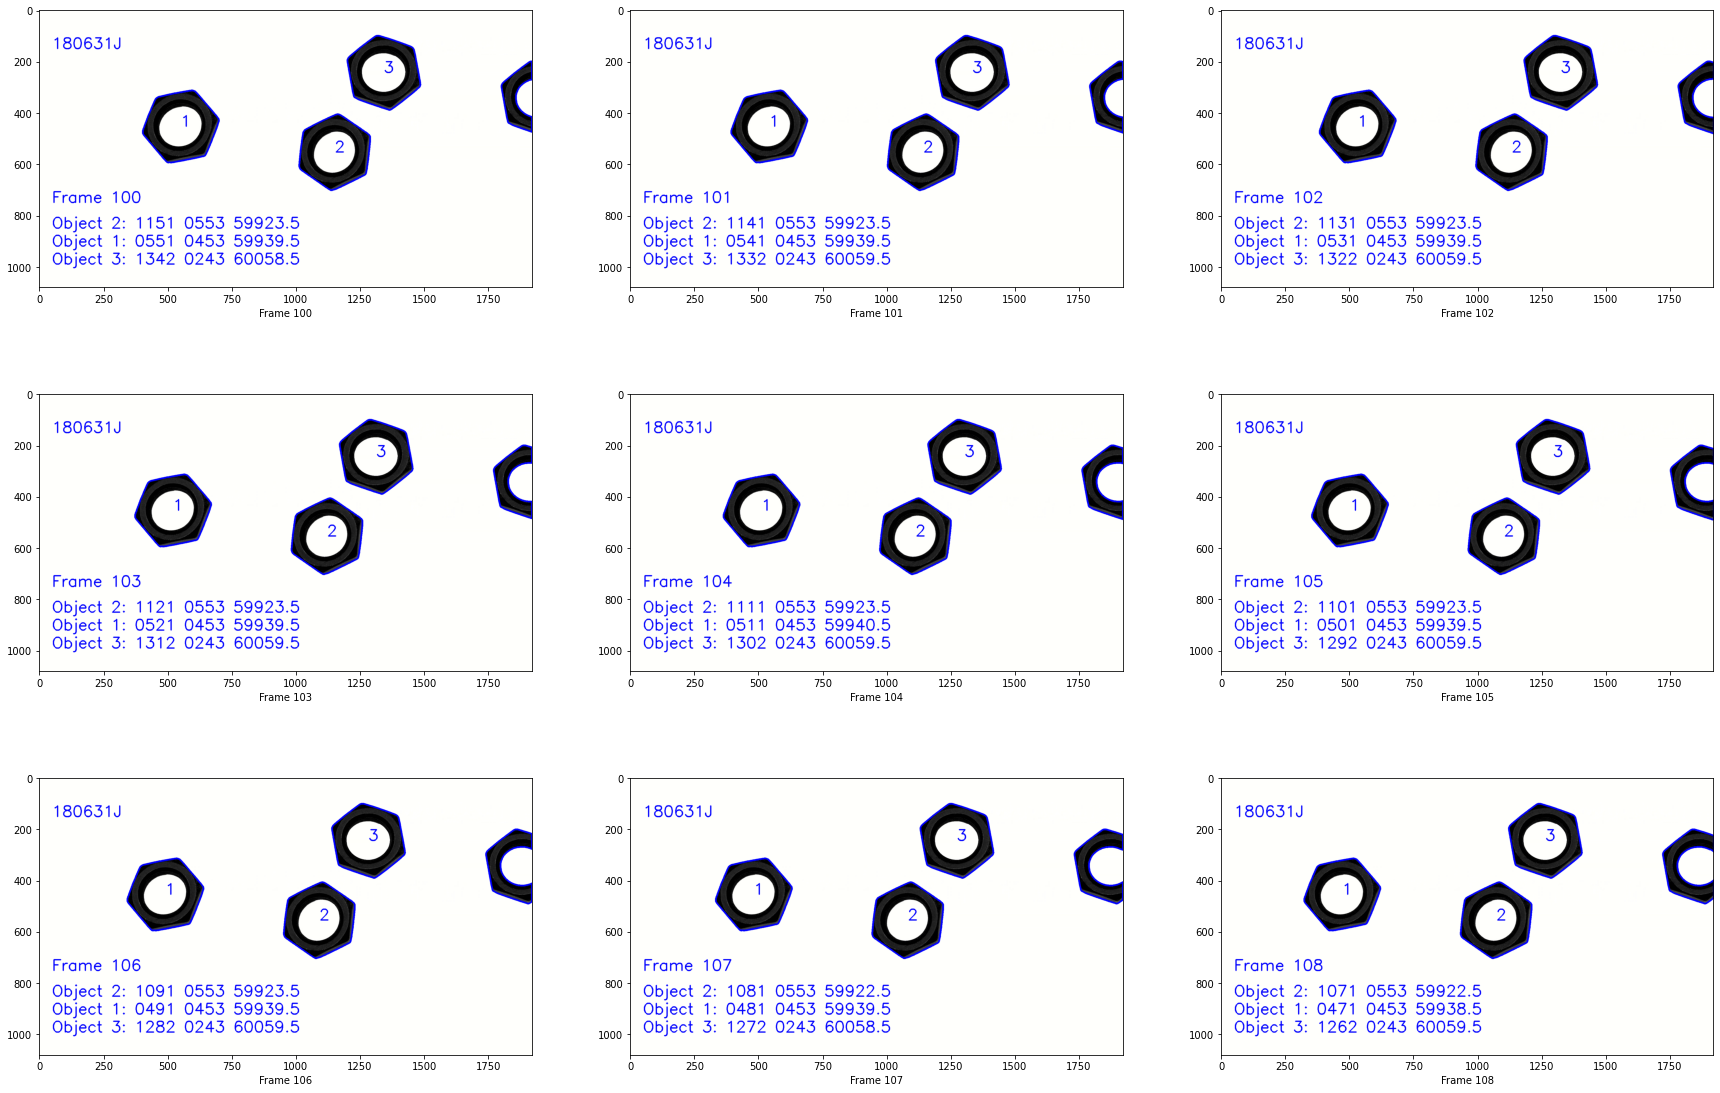

In [26]:
# visulaizing some annotated frames 
plt.figure(figsize=(30,20))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(annotated_frames[100 +i][:,:,::-1])
    plt.xlabel("Frame " + str(100 +i))
plt.show()

### Save the frames as a video

In [27]:
# Defining necessary parameters for video write

output = '180631j_en2550_a05.mp4' # Name of the output video file.
fourcc = cv.VideoWriter_fourcc(*'MP4V') # 4-character code of codec used to compress the frames
duration = 9 # duration of the source video
fps = int(len(annotated_frames)/duration) # Framerate of the created video stream
height, width,_ = annotated_frames[0].shape
frame_size = (width, height)
isColor = True # to write color images to the video
print('Frame Size(WxH) :', frame_size ,'\nFrames Per Second :', fps)

# Creating the Video Writer object
out = cv.VideoWriter(output, fourcc, fps, frame_size, isColor)
print("Video writer in progress...")
for frame in annotated_frames:
    out.write(frame)

# Release everything if job is finished
out.release()
print("Video writing completed.")

Frame Size(WxH) : (1920, 1080) 
Frames Per Second : 31
Video writer in progress...
Video writing completed.
